<a href="https://colab.research.google.com/github/KelllyChen/2025-Fall-XAI-Mechanistic-Interpretability/blob/notebook/AIPI_590_XAI_Mechanistic_Interpretability_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining a Tiny Brain
The purpose of this assignment is to build a tiny neural network, explore how it works from the inside, and explain the findings supported by code and visualizations.

## Import Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

## Data Generation
Here I first generated a synthetic dataset for a parity classification task. Each sample is an 8-bit binary vector consisting of 0s and 1s.
The label depends on the parity of the number of 1s in the vector:
- 0 if the number of 1s is even
- 1 if the number of 1s is odd

The dataset contains 2000 traingin samples and 500 validation samples.

In [ ]:
def generate_binary_data(n_samples=10000, seq_length=8):
    X = []
    y = []
    for _ in range(n_samples):
        binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
        total = sum(binary_str)
        if total%2==0:
          label=0
        else:
          label=1
        X.append(binary_str)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
n_classes = 2
X_train, y_train = generate_binary_data(2000, seq_length)
X_val, y_val = generate_binary_data(500, seq_length)

## Training
I designed a simple multilayer perceptron architecture for later interpretability. There were one input layer, two hidden layers with tanh activations, and one output layer in the model. The model is trained using the binary cross-entropy loss with logits and the Adam optimizer.

In [ ]:
class ParityMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))   # first hidden layer
        h2 = torch.tanh(self.fc2(h1))  # second hidden layer
        out = self.fc3(h2)             # output logit
        return out, (h1,h2)

model = ParityMLP(seq_length)
print(model)

# Binary cross-entropy
criterion = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

y_train_cls = y_train.float().unsqueeze(1)
y_val_cls = y_val.float().unsqueeze(1)

losses = []
for epoch in range(1000):
    model.train()
    logits, _ = model(X_train)
    loss = criterion(logits, y_train_cls)

    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())


model.eval()
with torch.no_grad():
    val_logits, H = model(X_val)
    probs = torch.sigmoid(val_logits)
    preds = (probs > 0.5).long().squeeze(1)
    acc = (preds == y_val).float().mean().item()
print(f"Validation accuracy: {acc:.3f}")
print(f"Final training loss: {losses[-1]:.4f}")


ParityMLP(
  (fc1): Linear(in_features=8, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
Validation accuracy: 0.994
Final training loss: 0.1038


## Example Input and Neuron Activations

To see how the model processes a single input, I passed in a single binary vector as an example and recorded the activations from both hidden layers.

Because both hidden layers use the tanh activation, each neuron outputs a value between -1 and 1.
- Values near +1 → the neuron is strongly activated, meaning the input pattern aligns well with what that neuron has learned to detect.
- Values near –1 → the neuron is strongly inhibited, indicating the input pattern is the opposite of what that neuron looks for.
- Values around 0 → the neuron is weakly responsive or uncertain for this input.

Since the output logit is a weighted sum, a neurn's direction only becomes "odd" or "even" after you account for its output weight sign. Therefore, by looking only at hidden activations, we can tell which neurons are active or inactive for a given input, but we can’t directly infer their class alignment (odd vs. even) without considering the corresponding output weights.

The two different example were provided to prove this.
[1, 1, 0, 1, 1, 1, 1, 1] and [1, 0, 1, 1, 1, 1, 1, 1] both have an odd number of 1s, but their neuron activations are not necessarily positive or negative.





In [ ]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 1, 0, 1, 1, 1, 1, 1]], dtype=torch.float32)
    logits, hidden = model(sample_input)
    prob = torch.sigmoid(logits).item()
    pred = int(prob > 0.5)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logit: {logits.item():.3f}, Prob(odd): {prob:.3f}, Pred: {pred}")


Sample Input: tensor([[1., 1., 0., 1., 1., 1., 1., 1.]])
Hidden Layer Activations: (tensor([[-0.8147, -0.7126, -0.9844, -0.9096, -0.9345, -0.8805, -0.0643, -0.9974,
          0.7511, -0.0666, -0.8945,  0.7975,  0.4251, -0.7454,  0.7611, -0.9791,
          0.9882, -0.6356, -0.8698, -0.2587]]), tensor([[-0.0930,  0.7980,  0.9198, -1.0000,  1.0000,  0.8582, -1.0000, -1.0000,
          0.1823, -1.0000]]))
Output Logit: 2.179, Prob(odd): 0.898, Pred: 1


Sample Input: [[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
logit: 2.179, prob(odd): 0.898, pred: 1


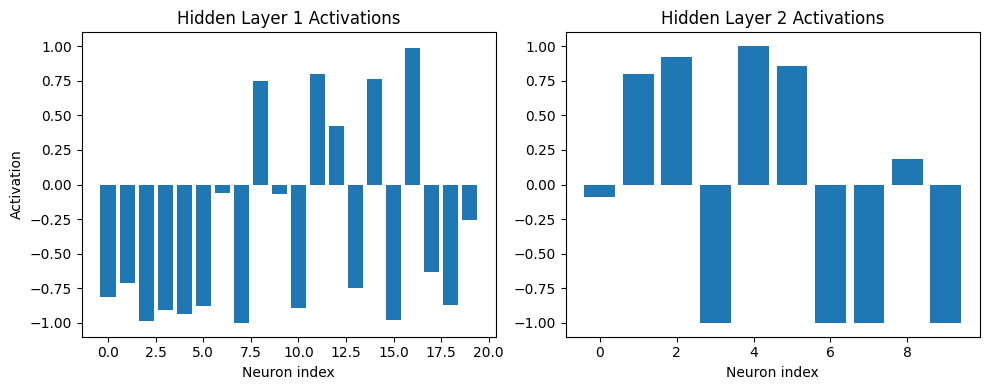

In [ ]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 1, 0, 1, 1, 1, 1, 1]], dtype=torch.float32)
    logits, (h1, h2) = model(sample_input)
    prob = torch.sigmoid(logits).item()
    pred = int(prob > 0.5)

print(f"Sample Input: {sample_input.tolist()}")
print(f"logit: {logits.item():.3f}, prob(odd): {prob:.3f}, pred: {pred}")

# Plot hidden layer activations
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Layer 1
axes[0].bar(range(len(h1[0])), h1[0].cpu().numpy())
axes[0].set_title("Hidden Layer 1 Activations")
axes[0].set_xlabel("Neuron index")
axes[0].set_ylabel("Activation")
axes[0].set_ylim(-1.1, 1.1)

# Layer 2
axes[1].bar(range(len(h2[0])), h2[0].cpu().numpy())
axes[1].set_title("Hidden Layer 2 Activations")
axes[1].set_xlabel("Neuron index")
axes[1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()


In [ ]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 1, 1, 1, 1, 1, 1]], dtype=torch.float32)
    logits, hidden = model(sample_input)
    prob = torch.sigmoid(logits).item()
    pred = int(prob > 0.5)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logit: {logits.item():.3f}, Prob(odd): {prob:.3f}, Pred: {pred}")


Sample Input: tensor([[1., 0., 1., 1., 1., 1., 1., 1.]])
Hidden Layer Activations: (tensor([[-0.7589, -0.5437, -0.9907, -0.9223, -0.9345, -0.8853, -0.1196, -0.9983,
          0.7751, -0.3814, -0.9536,  0.8237,  0.2434, -0.4620,  0.7784, -0.9672,
          0.9778, -0.5798, -0.9214, -0.4202]]), tensor([[-0.5247,  0.7750,  0.9164, -1.0000,  1.0000,  0.9210, -1.0000, -1.0000,
         -0.3735, -0.9999]]))
Output Logit: 3.611, Prob(odd): 0.974, Pred: 1


Sample Input: [[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
logit: 3.611, prob(odd): 0.974, pred: 1


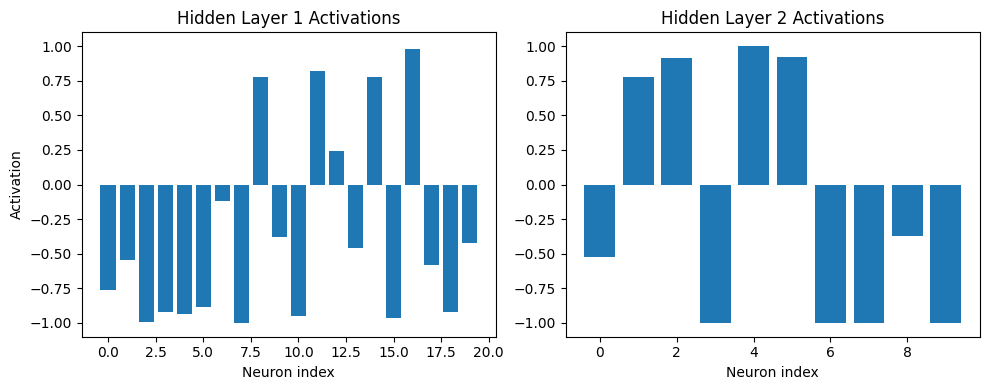

In [ ]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 1, 1, 1, 1, 1, 1]], dtype=torch.float32)
    logits, (h1, h2) = model(sample_input)
    prob = torch.sigmoid(logits).item()
    pred = int(prob > 0.5)

print(f"Sample Input: {sample_input.tolist()}")
print(f"logit: {logits.item():.3f}, prob(odd): {prob:.3f}, pred: {pred}")

# Plot hidden layer activations
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Layer 1
axes[0].bar(range(len(h1[0])), h1[0].cpu().numpy())
axes[0].set_title("Hidden Layer 1 Activations")
axes[0].set_xlabel("Neuron index")
axes[0].set_ylabel("Activation")
axes[0].set_ylim(-1.1, 1.1)

# Layer 2
axes[1].bar(range(len(h2[0])), h2[0].cpu().numpy())
axes[1].set_title("Hidden Layer 2 Activations")
axes[1].set_xlabel("Neuron index")
axes[1].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()


## Output Layer Weights

fc3.weight has shape [1, 10]. It takes 10 inputs (the activations from the second hidden layer) to produces one output logit.

Each weight tells us how much and in what direction that neuron influences the output.
- Positive weights amplify neurons that support predicting odd (class 1).
- Negative weights amplify neurons that support predicting even (class 0).
- The magnitude shows the importance of each neuron.

So the final decision comes from the combined influence of neurons with positive output weights and those with negative output weights.






In [ ]:
print("fc3 weights:", model.fc3.weight.shape)
print(model.fc3.weight)

fc3 weights: torch.Size([1, 10])
Parameter containing:
tensor([[-1.3120,  1.6574,  1.5037, -1.5775, -1.5931,  1.7003,  1.7435, -1.6132,
         -1.4428,  1.7181]], requires_grad=True)


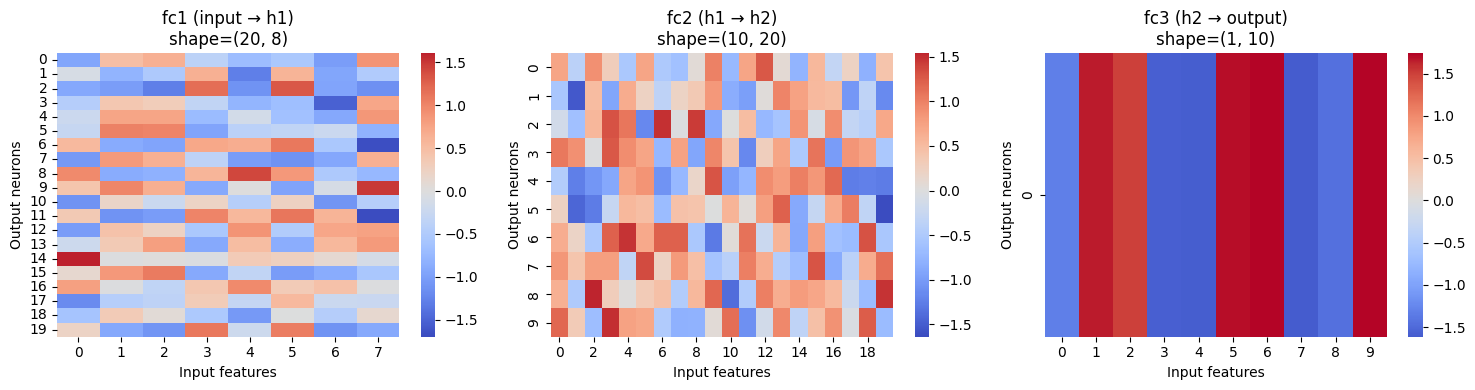

In [ ]:
def plot_weight_heatmaps(model):
    layers = []
    names  = []

    # collect weights
    if hasattr(model, 'fc1'):
        layers.append(model.fc1.weight.detach().numpy())
        names.append('fc1 (input → h1)')
    if hasattr(model, 'fc2'):
        layers.append(model.fc2.weight.detach().numpy())
        names.append('fc2 (h1 → h2)')
    if hasattr(model, 'fc3'):
        layers.append(model.fc3.weight.detach().numpy())
        names.append('fc3 (h2 → output)')
    elif hasattr(model, 'fc_out'):
        layers.append(model.fc_out.weight.detach().numpy())
        names.append('fc_out (h1 → output)')

    # plot
    fig, axes = plt.subplots(1, len(layers), figsize=(5*len(layers), 4))
    if len(layers) == 1:
        axes = [axes]

    for ax, W, name in zip(axes, layers, names):
        sns.heatmap(W, cmap="coolwarm", center=0, ax=ax)
        ax.set_title(f"{name}\nshape={W.shape}")
        ax.set_xlabel("Input features")
        ax.set_ylabel("Output neurons")

    plt.tight_layout()
    plt.show()

plot_weight_heatmaps(model)


## Example inputs and output weights
- Bars above 0 → neurons pushing the prediction toward odd (1).
- Bars below 0 → neurons pushing toward even (0).
- Longer bars → neurons with stronger influence (either supportive or opposing)

As shown in the following two cells, if the sum of positive contributions outweighs the negatives, the model predicts odd; if the opposite, it predicts even.

Output logit: 2.179, Prob(odd): 0.898
Per-neuron contributions:
 tensor([ 0.1221,  1.3226,  1.3830,  1.5775, -1.5930,  1.4592, -1.7435,  1.6131,
        -0.2630, -1.7180])


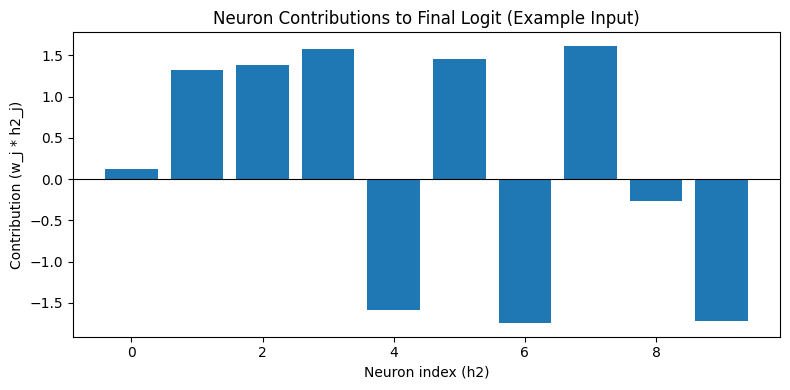

In [ ]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 1, 0, 1, 1, 1, 1, 1]], dtype=torch.float32)
    logit, (_, h2) = model(sample_input)

    # Below five lines were generated by GPT-5 on November 7th 5:30 p.m.
    # Get weights and bias from the output layer
    W_out = model.fc3.weight.squeeze(0)
    b_out = model.fc3.bias.item()

    # Compute per-neuron contributions
    contributions = h2.squeeze(0) * W_out
    total_logit = contributions.sum().item() + b_out
    prob = torch.sigmoid(torch.tensor(total_logit)).item()

print(f"Output logit: {total_logit:.3f}, Prob(odd): {prob:.3f}")
print("Per-neuron contributions:\n", contributions)

# Visualization
plt.figure(figsize=(8,4))
plt.bar(range(len(contributions)), contributions.numpy())
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Neuron Contributions to Final Logit (Example Input)")
plt.xlabel("Neuron index (h2)")
plt.ylabel("Contribution (w_j * h2_j)")
plt.tight_layout()
plt.show()


Output logit: -2.864, Prob(odd): 0.054
Per-neuron contributions:
 tensor([-1.1612, -1.5532, -1.4694,  1.5774, -1.5854,  1.7001, -1.7434,  1.6128,
         1.3996, -1.6611])


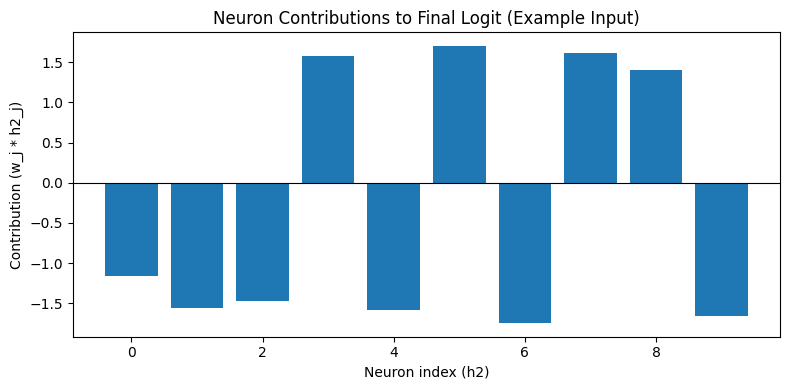

In [ ]:
with torch.no_grad():
    sample_input = torch.tensor([[0., 0., 1., 1., 1., 1., 1., 1.]], dtype=torch.float32)
    logit, (_, h2) = model(sample_input)

    # Get weights and bias from the output layer
    W_out = model.fc3.weight.squeeze(0)
    b_out = model.fc3.bias.item()

    # Compute per-neuron contributions
    contributions = h2.squeeze(0) * W_out
    total_logit = contributions.sum().item() + b_out
    prob = torch.sigmoid(torch.tensor(total_logit)).item()

print(f"Output logit: {total_logit:.3f}, Prob(odd): {prob:.3f}")
print("Per-neuron contributions:\n", contributions)

# Visualization
plt.figure(figsize=(8,4))
plt.bar(range(len(contributions)), contributions.numpy())
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Neuron Contributions to Final Logit (Example Input)")
plt.xlabel("Neuron index (h2)")
plt.ylabel("Contribution (w_j * h2_j)")
plt.tight_layout()
plt.show()


## Hidden Layer Activations Across Classes and Input Patterns
To understand what the model has learned, I used heatmaps to visualize the average neuron activations in each hidden layer for the two output classes(even vs. odd) and for different numbers of 1s as inputs.

- The first set of heatmap compares the mean activation of each neuron for the two output classes (0 = even, 1 = odd).
- The second set examines how activations change as the number of 1s in the input vector increases from 0 to 8.

The way to interpret of the activations is same as above, since both hidden layers use tanh activations, the output values lie between -1 and 1.
- Positive (yellow/green) → neuron outputs are positive → that feature is active for this class.
- Negative (purple) → neuron outputs are negative → the neuron is inhibited for this class.
- Near zero (blue/teal) → weak or neutral activation.





### Across Classes

**Hidden layer 1 (left heatmap)**
- There is no clear color difference between the even and odd columns for most neurons.

**Hidden layer 2 (right heatmap)**
- The differences between even and odd columns are more pronounced.

This means first hidden layer encodes mix and general features from the inputs, while the second layers has started to form class-specific representations.

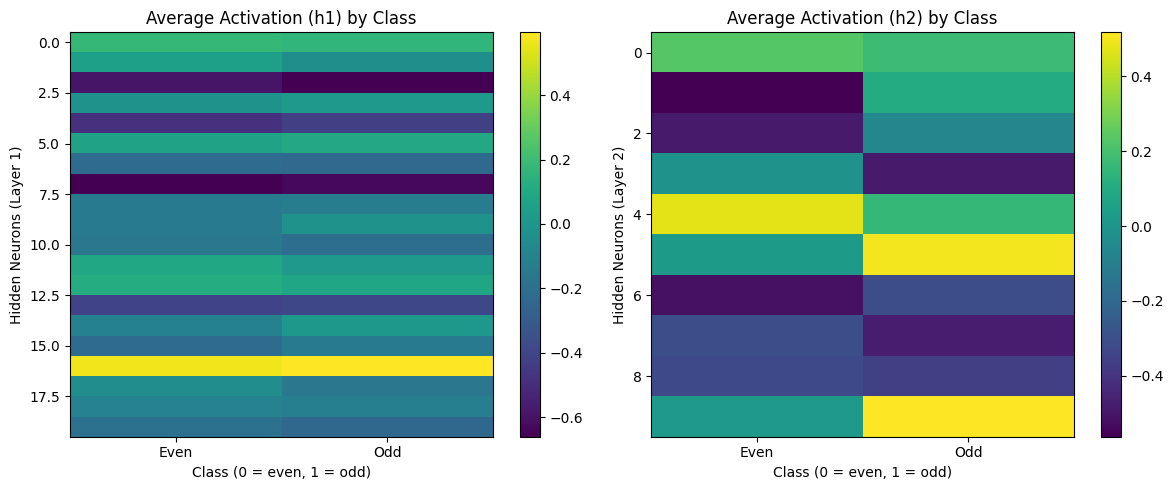

In [ ]:
num_neurons_h1 = 20   # number of neurons in first hidden layer
num_neurons_h2 = 10   # number of neurons in second hidden layer
counts = list(range(n_classes))

avg_h1 = torch.zeros((n_classes, num_neurons_h1))
avg_h2 = torch.zeros((n_classes, num_neurons_h2))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, (h1, h2) = model(class_inputs)
        avg_h1[c] = h1.mean(dim=0)
        avg_h2[c] = h2.mean(dim=0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap for h1
im1 = axes[0].imshow(avg_h1.T.detach().numpy(), aspect='auto', cmap='viridis')
axes[0].set_title("Average Activation (h1) by Class")
axes[0].set_xlabel("Class (0 = even, 1 = odd)")
axes[0].set_ylabel("Hidden Neurons (Layer 1)")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Even", "Odd"])
plt.colorbar(im1, ax=axes[0])

# Heatmap for h2
im2 = axes[1].imshow(avg_h2.T.detach().numpy(), aspect='auto', cmap='viridis')
axes[1].set_title("Average Activation (h2) by Class")
axes[1].set_xlabel("Class (0 = even, 1 = odd)")
axes[1].set_ylabel("Hidden Neurons (Layer 2)")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Even", "Odd"])
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


### Across Input Patterns

When looking only at the two heatmaps, there is no clear or consistent activation pattern across the number of 1s for most neurons in either hidden layer.

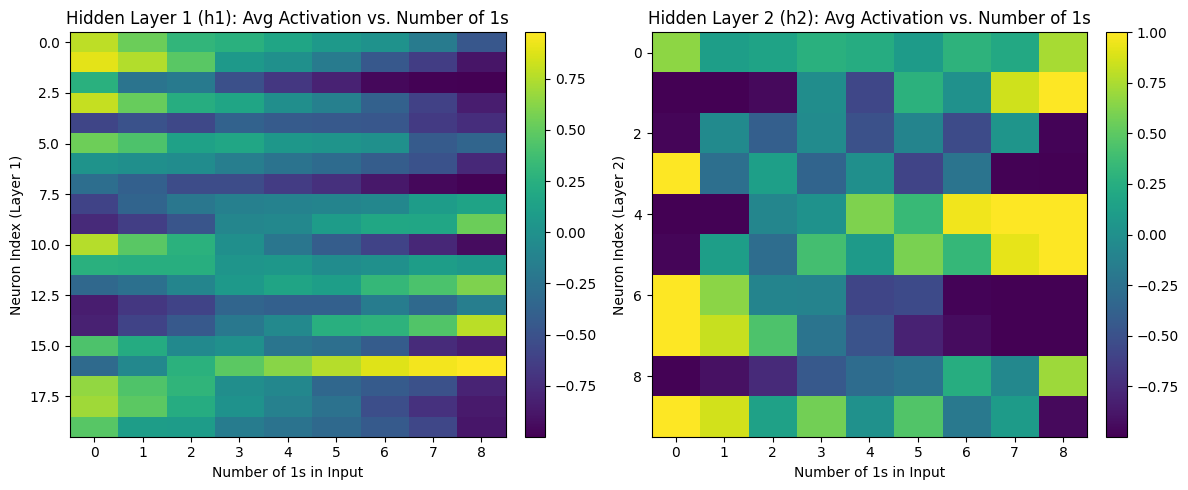

In [ ]:
counts = list(range(seq_length + 1))

avg_h1 = torch.zeros((len(counts), num_neurons_h1))
avg_h2 = torch.zeros((len(counts), num_neurons_h2))

for c in counts:
    mask = (X_val.sum(dim=1) == c)   # samples with exactly c ones
    class_inputs = X_val[mask]
    if class_inputs.shape[0] > 0:
        _, (h1, h2) = model(class_inputs)
        avg_h1[c] = h1.mean(dim=0)
        avg_h2[c] = h2.mean(dim=0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Layer 1
im1 = axes[0].imshow(avg_h1.T.detach().numpy(), aspect='auto', cmap='viridis')
axes[0].set_title("Hidden Layer 1 (h1): Avg Activation vs. Number of 1s")
axes[0].set_xlabel("Number of 1s in Input")
axes[0].set_ylabel("Neuron Index (Layer 1)")
axes[0].set_xticks(range(len(counts)))
axes[0].set_xticklabels(counts)
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Layer 2
im2 = axes[1].imshow(avg_h2.T.detach().numpy(), aspect='auto', cmap='viridis')
axes[1].set_title("Hidden Layer 2 (h2): Avg Activation vs. Number of 1s")
axes[1].set_xlabel("Number of 1s in Input")
axes[1].set_ylabel("Neuron Index (Layer 2)")
axes[1].set_xticks(range(len(counts)))
axes[1].set_xticklabels(counts)
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


But we can plot it as a line chart to see whether any clearer patterns or changes emerge.

While the heatmaps did not show an obvious pattern, plotting individual neuron activations against the number of 1s reveals a zig-zag pattern. For example neuron 9 in layer2 shows higher positive values for certain counts and lower (even negative) values for others.

This alternating behavior suggests that the neuron is sensitive to parity, it responds differently depending on whether the count of 1s is even or odd.

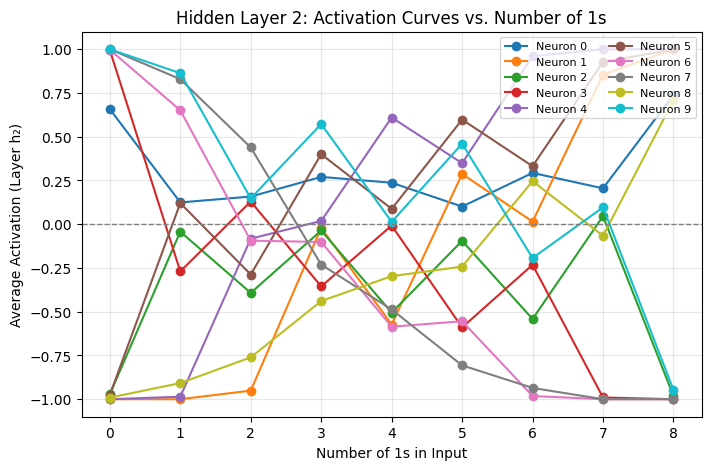

In [ ]:
counts = list(range(seq_length + 1))

plt.figure(figsize=(8, 5))

for i in range(avg_h2.shape[1]):  # each neuron in layer 2
    plt.plot(counts, avg_h2[:, i].detach().numpy(), marker='o', label=f'Neuron {i}')

plt.xlabel("Number of 1s in Input")
plt.ylabel("Average Activation (Layer h₂)")
plt.title("Hidden Layer 2: Activation Curves vs. Number of 1s")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend(ncol=2, fontsize=8, loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()


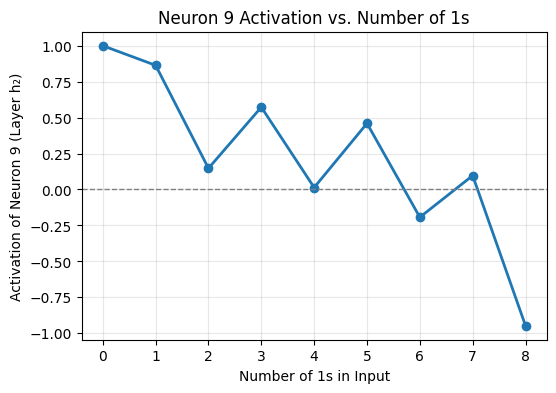

In [ ]:
# Second layer

counts = list(range(seq_length + 1))  #
neuron_idx = 9

plt.figure(figsize=(6, 4))
plt.plot(counts, avg_h2[:, neuron_idx].detach().numpy(), marker='o', linewidth=2)

plt.xlabel("Number of 1s in Input")
plt.ylabel(f"Activation of Neuron {neuron_idx} (Layer h₂)")
plt.title(f"Neuron {neuron_idx} Activation vs. Number of 1s")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.show()


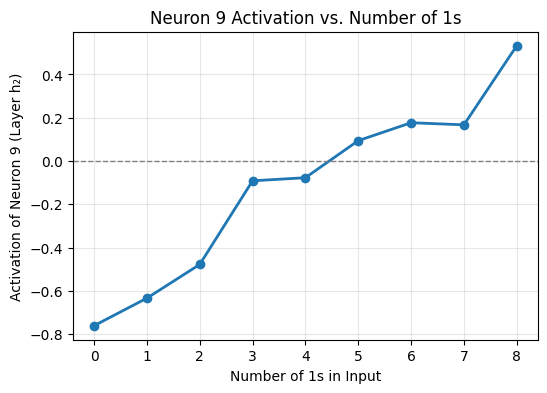

In [ ]:
# first layer

counts = list(range(seq_length + 1))
neuron_idx = 9

plt.figure(figsize=(6, 4))
plt.plot(counts, avg_h1[:, neuron_idx].detach().numpy(), marker='o', linewidth=2)

plt.xlabel("Number of 1s in Input")
plt.ylabel(f"Activation of Neuron {neuron_idx} (Layer h₂)")
plt.title(f"Neuron {neuron_idx} Activation vs. Number of 1s")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.show()


## Neuron Ablation (single neuron)
The following cell tests the effect of zeroing out a specific neuron to examine how much it influences the model’s prediction.

For example, when neuron 9 in layer 2 is set to zero, the predicted probability of the input being odd increases by 0.098. However, since the final probability is still under 0.5, the overall classification does not change.

In [ ]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_label = int(test_input.sum().item() % 2)

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_logit = baseline_output.item()
    baseline_prob  = torch.sigmoid(baseline_output).item()
    baseline_pred  = int(baseline_prob > 0.5)

# Zero out one neuron in the hidden layer
neuron_to_zero = 9

# Manually run forward pass with neuron ablated
with torch.no_grad():
    h1 = torch.tanh(model.fc1(test_input))
    h2 = torch.tanh(model.fc2(h1))

    # zero out neuron 9 in h2
    h2[:, neuron_to_zero] = 0

    # continue forward to output
    modified_output = model.fc3(h2)
    modified_logit = modified_output.item()
    modified_prob  = torch.sigmoid(modified_output).item()
    modified_pred  = int(modified_prob > 0.5)


print(f"True label: {true_label}")
print("Baseline prediction")
print(f"Logit: {baseline_logit:.3f}  | Prob(odd): {baseline_prob:.3f}  | Pred: {baseline_pred}")
print(f"With neuron {neuron_to_zero} zeroed")
print(f"Logit: {modified_logit:.3f}  | Prob(odd): {modified_prob:.3f}  | Pred: {modified_pred}")

d_logit = modified_logit - baseline_logit
d_prob  = modified_prob  - baseline_prob
print(f"\nΔ Logit: {d_logit:+.3f}  | Δ Prob(odd): {d_prob:+.3f}")



True label: 0
Baseline prediction
Logit: -3.602  | Prob(odd): 0.027  | Pred: 0
With neuron 9 zeroed
Logit: -1.953  | Prob(odd): 0.124  | Pred: 0

Δ Logit: +1.648  | Δ Prob(odd): +0.098


## Neuron Ablation (sweep of neurons)
Except for setting a specific neuron to zero, I also zeroed out each neuron one at a time to see if there were any neurons in layer 2 that strongly influenced the outputs.

According to the bar plot, some neurons increase the predicted probability of the input being odd, while others decrease it. However, there is no single neuron that strongly changes the output, the increase or decrease is less than ±0.1.


🧾 True count: 0, Baseline prediction: 0.00


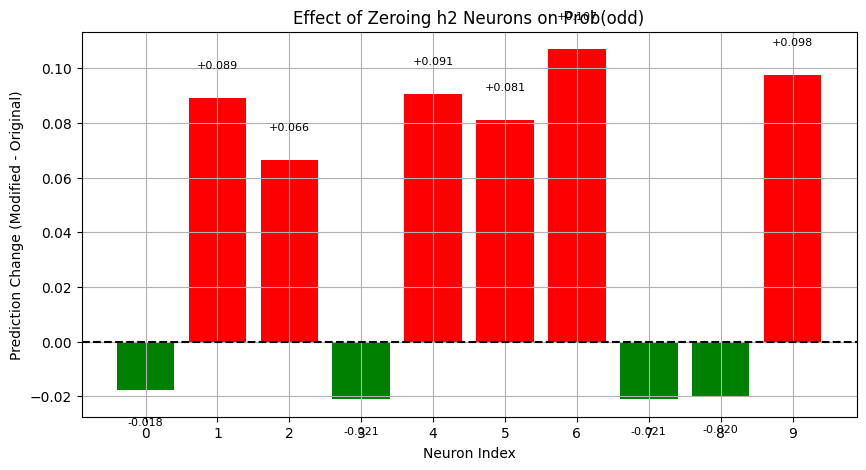

Neuron 0 → Prediction decreased by 0.02
Neuron 1 → Prediction increased by 0.09
Neuron 2 → Prediction increased by 0.07
Neuron 3 → Prediction decreased by 0.02
Neuron 4 → Prediction increased by 0.09
Neuron 5 → Prediction increased by 0.08
Neuron 6 → Prediction increased by 0.11
Neuron 7 → Prediction decreased by 0.02
Neuron 8 → Prediction decreased by 0.02
Neuron 9 → Prediction increased by 0.10


In [ ]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_label = int(test_input.sum().item() % 2)

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    base_prob  = torch.sigmoid(baseline_output).item()
    base_pred = int(base_prob > 0.5)

print(f"🧾 True count: {true_label}, Baseline prediction: {baseline_pred:.2f}")

# Sweep: get signed change in scalar prediction
neuron_indices = list(range(model.fc2.out_features))
signed_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h1 = torch.tanh(model.fc1(test_input))
        h2 = torch.tanh(model.fc2(h1))


        h2[:, i] = 0

        # continue forward to output
        modified_logit = model.fc3(h2)
        modified_prob  = torch.sigmoid(modified_logit).item()
        #modified_pred  = int(modified_prob > 0.5)
        signed_deltas.append(modified_prob - baseline_prob)

# Plotting signed prediction change per neuron
plt.figure(figsize=(10, 5))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Effect of Zeroing h2 Neurons on Prob(odd)")
plt.grid(True)

# Annotatation
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.01 if d > 0 else -0.01), f"{d:+.3f}",
                 ha='center', va='bottom' if d > 0 else 'top', fontsize=8)

plt.show()

# Summary
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")


## Reflection

Since the time I started learning AI, I've built many different kinds of ml models, but I never truly looked into what was happening inside them. I knew about different activation functions, loss functions, and model structures, but I realized that even though I could explain these concepts, I did not actually understand how they worked within the model.

Through the above exploration, I learned how a model operates internally and how to interpret the output of each neuron. The computations inside the network have become concrete rather than abstract.

For further exploration, it would be interesting to study how neurons are connected from the first hidden layer to the second (in my case, from 8 → 20 → 10 → 1), and to analyze why not all neurons in the second layer show clear zig-zag activation patterns with different input counts of 1s. Understanding what the other neurons are doing could reveal more about how the model passes information across layers.